In [2]:
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import Deep learning Libraries
#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Generate data paths with labels
train_data_dir = r"D:\CAPSTONE 400A\final_dataset\pneumonia\chest_xray\train"
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
1,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
2,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
3,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
4,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
...,...,...
5211,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA
5212,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA
5213,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA
5214,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA


In [5]:
val_data_dir = r"D:\CAPSTONE 400A\final_dataset\pneumonia\chest_xray\val"
filepaths = []
labels = []
folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)
valid_df

,filepaths,labels
0,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
1,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
2,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
3,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
4,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
5,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
6,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
7,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
8,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA
9,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA


In [6]:
test_data_dir =r"D:\CAPSTONE 400A\final_dataset\pneumonia\chest_xray\test"
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
test_df

,filepaths,labels
0,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
1,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
2,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
3,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
4,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,NORMAL
...,...,...
619,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA
620,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA
621,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA
622,D:\CAPSTONE 400A\final_dataset\pneumonia\chest...,PNEUMONIA


In [7]:
batch_size = 8
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


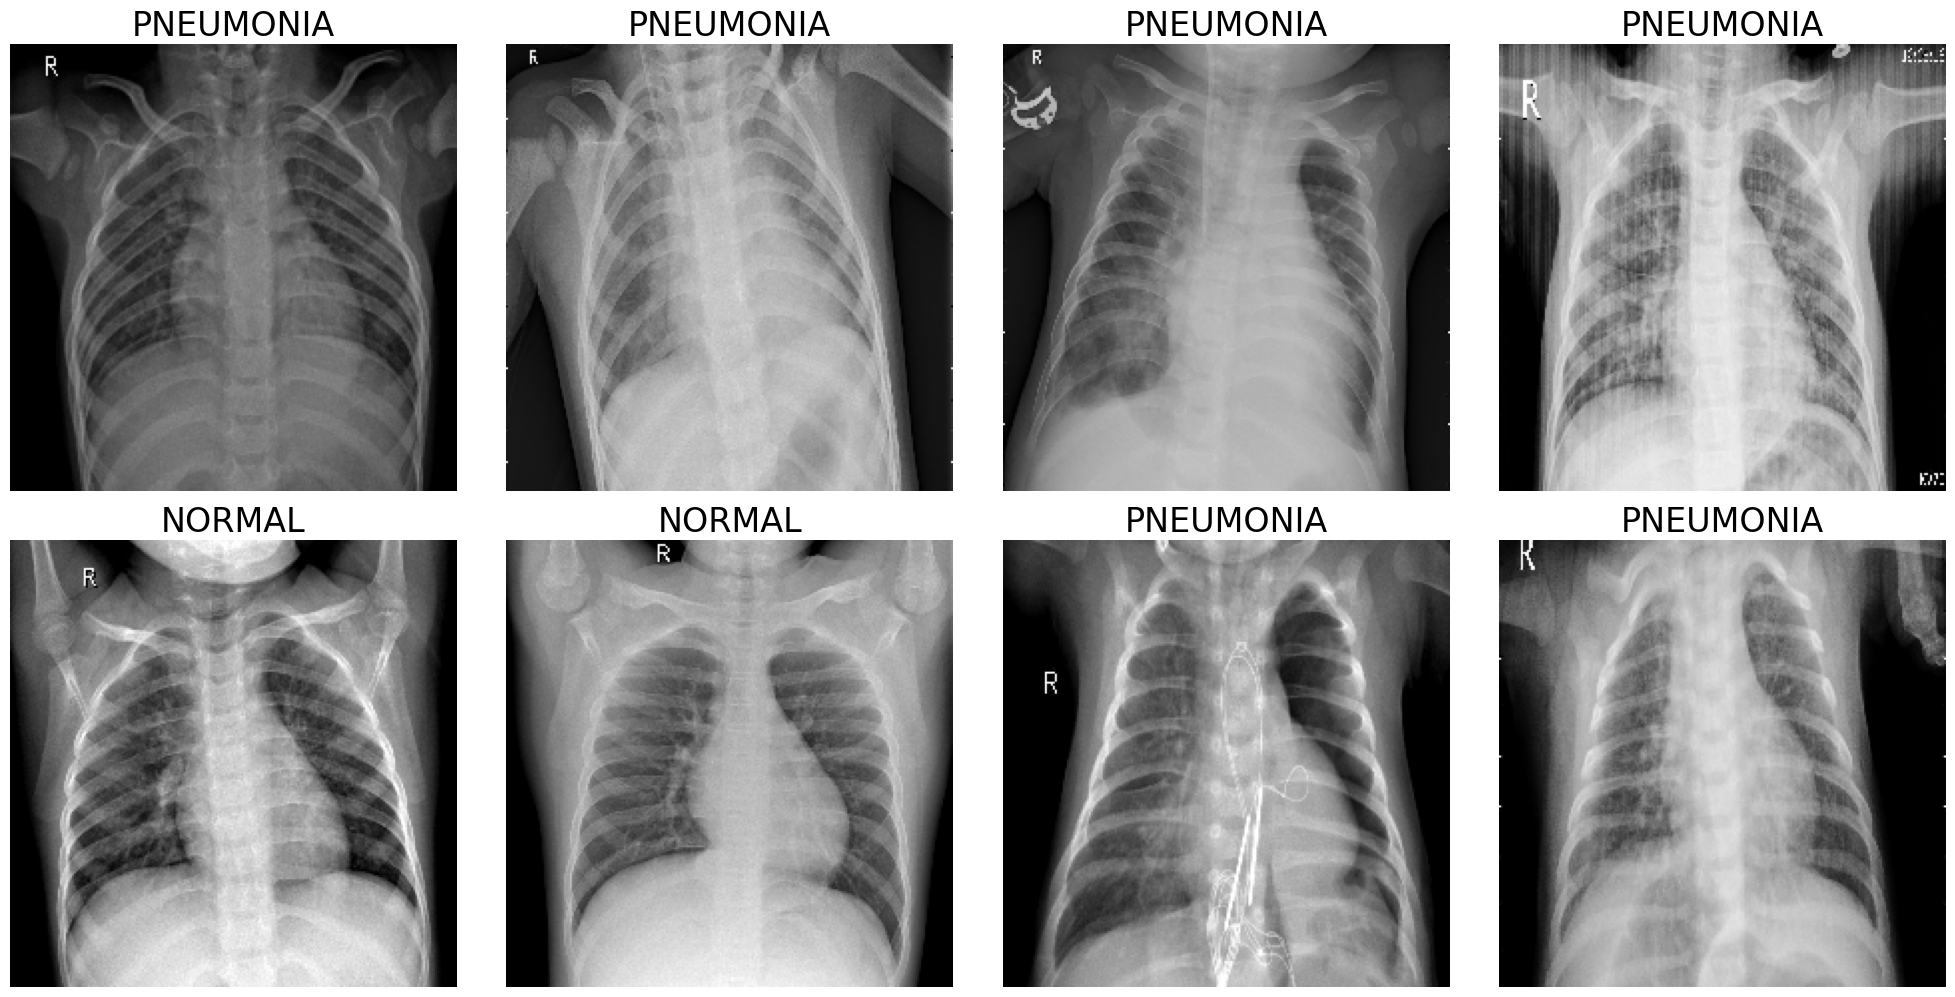

In [9]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i]) 
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 24)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.layers import MaxPooling2D
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) 

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [11]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

16705208/16705208 [==============================] - 25s 1us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                      

In [12]:
batch_size = 8   
epochs = 10  

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/10
652/652 [==============================] - 1450s 2s/step - loss: 3.8796 - accuracy: 0.9247 - val_loss: 2.3397 - val_accuracy: 0.7500
Epoch 2/10
652/652 [==============================] - 1659s 3s/step - loss: 1.2306 - accuracy: 0.9617 - val_loss: 1.7271 - val_accuracy: 0.5000
Epoch 3/10
652/652 [==============================] - 1785s 3s/step - loss: 0.5680 - accuracy: 0.9735 - val_loss: 0.6945 - val_accuracy: 0.7500
Epoch 4/10
652/652 [==============================] - 1782s 3s/step - loss: 0.3365 - accuracy: 0.9795 - val_loss: 0.2564 - val_accuracy: 1.0000
Epoch 5/10
652/652 [==============================] - 1175s 2s/step - loss: 0.2168 - accuracy: 0.9906 - val_loss: 0.2674 - val_accuracy: 0.9375
Epoch 6/10
652/652 [==============================] - 1169s 2s/step - loss: 0.1572 - accuracy: 0.9948 - val_loss: 0.1538 - val_accuracy: 1.0000
Epoch 7/10
652/652 [==============================] - 1187s 2s/step - loss: 0.1325 - accuracy: 0.9927 - val_loss: 0.1064 - val_accuracy:

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, vAerbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 [==============================] - 7s 784ms/step - loss: 1.7002 - accuracy: 0.6094
Train Loss:  0.06859343498945236
Train Accuracy:  1.0
--------------------
Validation Loss:  0.07609859108924866
Validation Accuracy:  1.0
--------------------
Test Loss:  1.70017409324646
Test Accuracy:  0.609375


In [14]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1) 

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       1.00      0.40      0.57       234
   PNEUMONIA       0.73      1.00      0.85       390

    accuracy                           0.77       624
   macro avg       0.87      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624



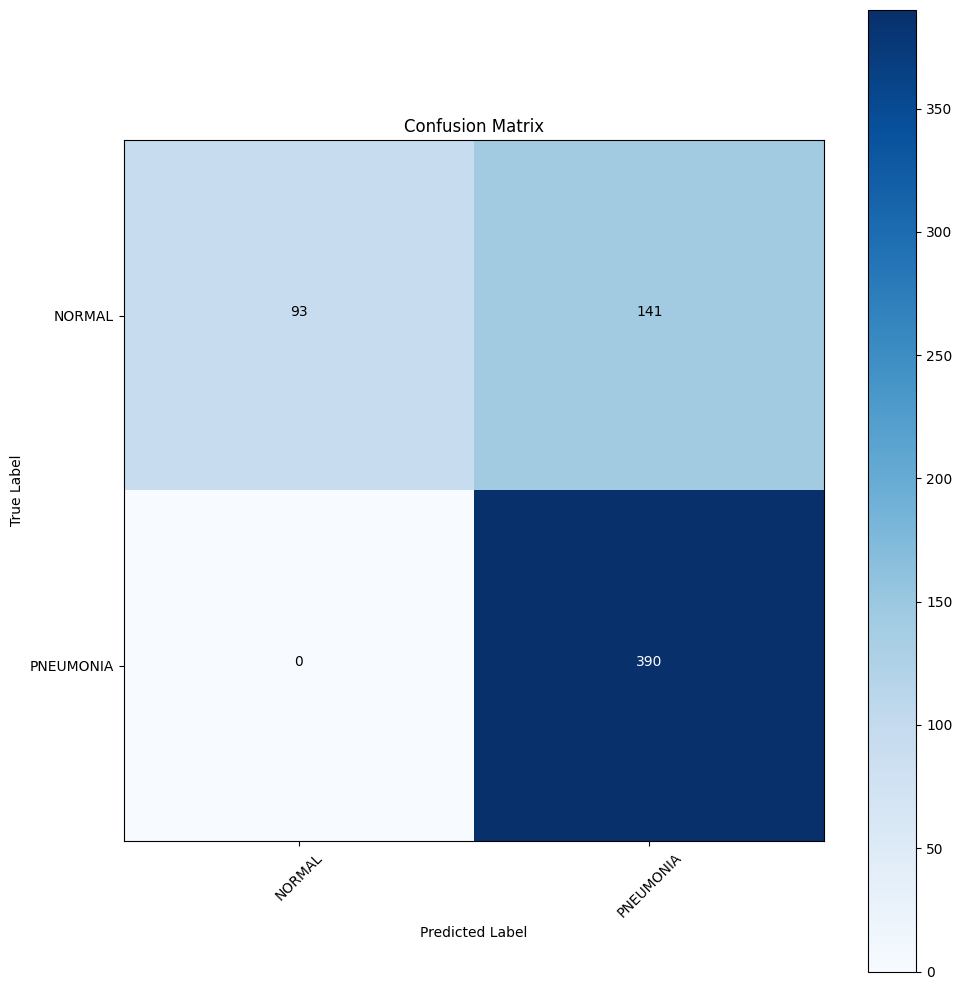

In [16]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

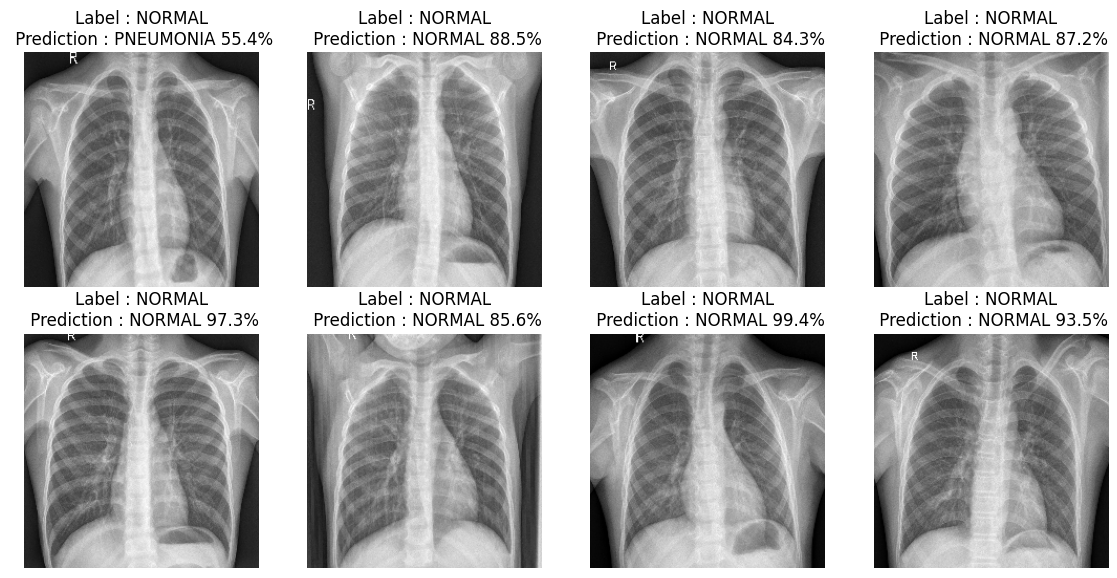

In [34]:
class_names = list(train_gen.class_indices.keys())

test_gen.reset()
img, label = next(test_gen)

preds = model.predict_generator(img)
y_pred = np.argmax(preds, axis=1) 

plt.figure(figsize=[14, 14])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(img[i] / 255)  # Normalize image data
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[y_pred[i]], 100 * np.max(preds[i])))
plt.show()


In [37]:
import tensorflow as tf
import pickle

# Save the model in HDF5 format
model.save(r"D:\CAPSTONE 400A\model\tryb.h5")

In [38]:
# Save the model in Pickle format
with open("D:\CAPSTONE 400A\model\densetry.pkl", 'wb') as pickle_file:
    pickle.dump(model, pickle_file)

In [39]:
loaded_model = tf.keras.models.load_model(r"D:\CAPSTONE 400A\model\tryb.h5", compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [45]:
image_path = r"D:\CAPSTONE 400A\final_dataset\pneumonia\chest_xray\train\NORMAL\IM-0170-0001.jpeg"
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 1)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[1])
print(f"{class_labels[tf.argmax(score)]}")

7/7 [==============================] - 4s 25ms/step
NORMAL


In [50]:
image_path = r"D:\CAPSTONE 400A\final_dataset\pneumonia\chest_xray\test\PNEUMONIA\person15_virus_46.jpeg"
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 216ms/step
PNEUMONIA
